# Analysis on Child's IQ

This analysis mainly contain three part:
1. **Data Prepare and Manipulation**: load the raw data and then prepare the dataframe for further analysis
2. **Exploratory Data Analysis**: conduct univariant, bivariant EDA and explore for interaction effect on child's IQ
3. **Linear Regression**: build 3 linear regression models with a single predictor, multiple predictors and multiple predictors with interaction terms including model selection, diagostics and interpretation.Then, three models are compared and further possible analysis is discussed

## Data Prepare and Manipulation
 
 In this part, data are loaded and manipulated for further analysis including:
 1. Read the raw data
 2. Prepare the structured data for analysis
 3. Clean the data and convert the variables to suitable Dtype.

In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import pylab as py
import statsmodels.api as sm

In [2]:
# read raw data
raw = pd.read_csv('/Users/zhaotong/Desktop/JP_THA/data.txt',
                  encoding = 'unicode_escape',delimiter='|')
raw.head()

,,variable,value
0,0,score,65
1,1,score,98
2,2,score,85
3,3,score,83
4,4,score,115


This is a long table with one column indicating variable and the other indicating value of corresponding variable. So it needs to be pivoted to a structured table for analysis. 

In [3]:
# Delete the first useless column 
raw_copy = raw.iloc[:,1:]

In [4]:
# Separate the data by variables
score = raw_copy[raw_copy.variable=='score'].reset_index().value
a = raw_copy[raw_copy.variable=='a'].reset_index().value
h = raw_copy[raw_copy.variable=='h'].reset_index().value
w = raw_copy[raw_copy.variable=='w'].reset_index().value
i = raw_copy[raw_copy.variable=='i'].reset_index().value

#Check if they have the same lenth
assert len(score)==len(a)==len(h)==len(w)==len(i)

However, there is no label to link the variables so I just merge them by column.

In [5]:
# Merge the data and rename the variables
df = pd.concat([score,a,h,w,i], axis=1)
df.columns = ['child_IQ',
              'm_age_birth',
              'm_high_school_idx',
              'm_work_status_idx',
              'm_IQ']
df.head()

,child_IQ,m_age_birth,m_high_school_idx,m_work_status_idx,m_IQ
0,65,27,1,4,'121.117528602603'
1,98,25,1,4,'89.3618817100663'
2,85,27,1,4,'115.443164881725'
3,83,25,1,3,'99.4496394360723'
4,115,27,1,4,'92.7457099982118'


**Propose the types of data**: In this dataset, the IQ of mother and child should be float. Other variable should be int.

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 434 entries, 0 to 433
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   child_IQ           434 non-null    object
 1   m_age_birth        434 non-null    object
 2   m_high_school_idx  434 non-null    object
 3   m_work_status_idx  434 non-null    object
 4   m_IQ               434 non-null    object
dtypes: object(5)
memory usage: 17.1+ KB


However from the information above, luckily there is no missing value in the dataset but there is two thing need to be done:
1. The variable Mother's IQ(m_IQ) contains quotation marks need to be eliminated then convert to a numeric variable
2. The type of other variables are object other than numeric 


In [7]:
# make a copy to keep the record
df_copy1 = df

In [8]:
# Deal with 'm_IQ'
df.m_IQ = df.m_IQ.str.strip("''").astype(float)

In [9]:
# Convert the IQ of child(child_IQ) to float and other variable to int.
df.child_IQ = df.child_IQ.astype('float')
df[['m_age_birth', 'm_high_school_idx','m_work_status_idx']] = df[['m_age_birth', 'm_high_school_idx','m_work_status_idx']].astype('int')

df.head()

,child_IQ,m_age_birth,m_high_school_idx,m_work_status_idx,m_IQ
0,65.0,27,1,4,121.117529
1,98.0,25,1,4,89.361882
2,85.0,27,1,4,115.443165
3,83.0,25,1,3,99.449639
4,115.0,27,1,4,92.745710


Here we add 2 variable to indicate mother's high school education and work status in first three years of child’s life in order to perform EDA easier.

In [10]:
# Add 2 variables about mother education and work status
dummy_mapping = {1:'yes',0:"no"}
df['m_high_school'] = df['m_high_school_idx'].map(dummy_mapping)

work_mapping = {1: 'no work',
                2: 'work in 2nd/3rd yr',
                3: 'part-time',
                4: 'full-time'}
df['m_work_status'] = df['m_work_status_idx'].map(work_mapping)

df.head()

,child_IQ,m_age_birth,m_high_school_idx,m_work_status_idx,m_IQ,m_high_school,m_work_status
0,65.0,27,1,4,121.117529,yes,full-time
1,98.0,25,1,4,89.361882,yes,full-time
2,85.0,27,1,4,115.443165,yes,full-time
3,83.0,25,1,3,99.449639,yes,part-time
4,115.0,27,1,4,92.745710,yes,full-time


In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 434 entries, 0 to 433
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   child_IQ           434 non-null    float64
 1   m_age_birth        434 non-null    int64  
 2   m_high_school_idx  434 non-null    int64  
 3   m_work_status_idx  434 non-null    int64  
 4   m_IQ               434 non-null    float64
 5   m_high_school      434 non-null    object 
 6   m_work_status      434 non-null    object 
dtypes: float64(2), int64(3), object(2)
memory usage: 23.9+ KB


Here the infomation table tells that all variables are what we expected.

### Summary
In this part, tha data is prepared for EDA and regression:
1. The raw data is pivoted to a wider table with raws as observations and columns as variables. And the variables are renamed:
    * child_IQ: child's IQ
    * m_age_birth: mother's age at child's birth
    * m_IQ: mother's IQ
    * m_high_school_idx: indicator showing whether mother completed high school (1=True, 0=False)
    * m_work_status_idx: indicator showing mother's work status in first three years of child’s life
2. Variables are converted to suitable Dtype as decribed in the info table above.
3. 2 additional variables are created for EDA:
    * m_high_school: whether mother completed high school (1='yes', 0='no')
    * m_work_status: mother's work status work status in first three years of child’s life(1='no work',2='work in 2nd/3rd yr',3='part-time',4='full-time')


## Exploratory Data Analysis
This EDA part starts with univariant analysis in which the distribution of variables is ploted. Then, bivariant relationship is ploted to find the correlation between variables. Finally, the interaction effect between predictors are explored in order to add appropriate interaction terms in regression model.

### Univariant Analysis
#### continuous variables

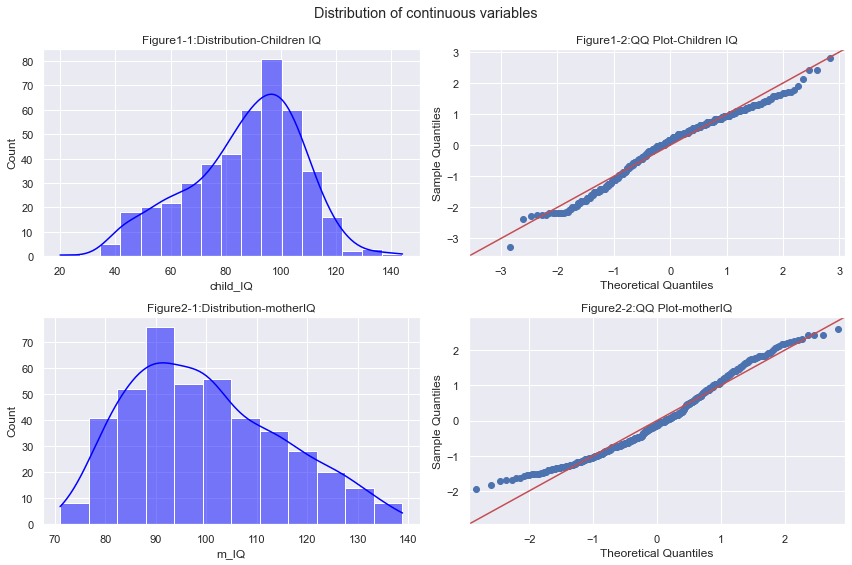

In [12]:
sns.set_theme()
fig,ax = plt.subplots(2,2,figsize=(12,8))
fig.suptitle('Distribution of continuous variables')

sns.histplot(data=df, x='child_IQ',
            color="blue",kde=True, 
            ax=ax[0,0])
ax[0,0].set_title('Figure1-1:Distribution-Children IQ')
sm.qqplot((df.child_IQ-df.child_IQ.mean())/df.child_IQ.std(),
          line ='45',
          ax=ax[0,1])
ax[0,1].set_title('Figure1-2:QQ Plot-Children IQ')

sns.histplot(data=df, x='m_IQ',
            color="blue",kde=True, 
            ax=ax[1,0])
ax[1,0].set_title('Figure2-1:Distribution-motherIQ')
sm.qqplot((df.m_IQ-df.m_IQ.mean())/df.m_IQ.std(),
          line ='45',
          ax=ax[1,1])
ax[1,1].set_title('Figure2-2:QQ Plot-motherIQ')

plt.tight_layout()
plt.show()

Figure1 and Figure2 shows the distribution and QQ plot of child's IQ and mother's IQ. It is found that:
1. There is no obvious outlier in 'child_IQ' and 'm_IQ'
2. 'child_IQ' is slightly left-skewed. However in Linear Regression, the regressand is expected to be normally ditributed. Therefore, the Box-Cox Transformation will be applied on 'child-IQ', which is shown below:

In [13]:
from scipy import stats
trans_c_IQ, fitted_lambda = stats.boxcox(df.child_IQ)
fitted_lambda

1.6226943871171287

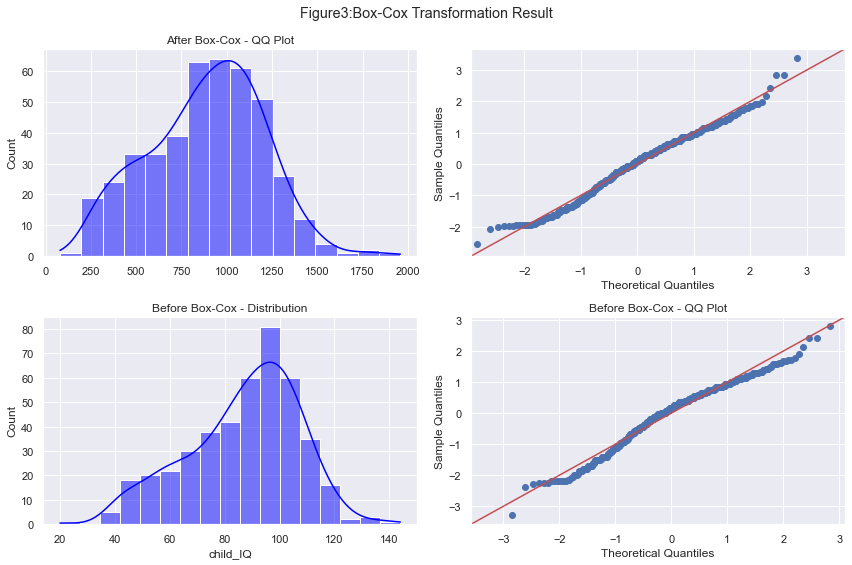

In [14]:
fig,ax = plt.subplots(2,2,figsize=(12,8))
fig.suptitle('Figure3:Box-Cox Transformation Result')

ax[0,0].set_title('After Box-Cox - Distribution')
ax[0,0].set_title('After Box-Cox - QQ Plot')
sns.histplot(trans_c_IQ,color="blue",kde=True, 
            ax=ax[0,0])
sm.qqplot((trans_c_IQ-trans_c_IQ.mean())/trans_c_IQ.std(),
          line ='45',
          ax=ax[0,1])

ax[1,0].set_title('Before Box-Cox - Distribution')
ax[1,1].set_title('Before Box-Cox - QQ Plot')
sns.histplot(data=df, x='child_IQ',
            color="blue",kde=True, 
            ax=ax[1,0])
sm.qqplot((df.child_IQ-df.child_IQ.mean())/df.child_IQ.std(),
          line ='45',
          ax=ax[1,1])

plt.tight_layout()
plt.show()

In Figure3, The distribution is less skewed after transformation. So the transformed child_IQ(trans_c_IQ) will be used in Linear Regression.

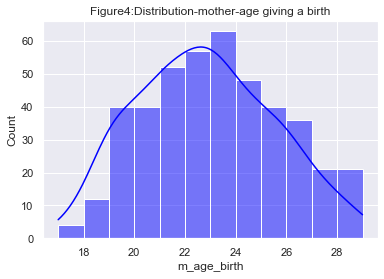

In [15]:
sns.histplot(data=df, x='m_age_birth',
            color="blue",kde=True)
plt.title('Figure4:Distribution-mother-age giving a birth')
plt.show()

Technically, the variable 'm_age_birth'(mother's age when giving a birth) is not a continuous variable. Here it is often regarded as a continuous one in analysis for convenience. Also, there is no outlier in 'm_age_birth'.

#### Categorical Variables

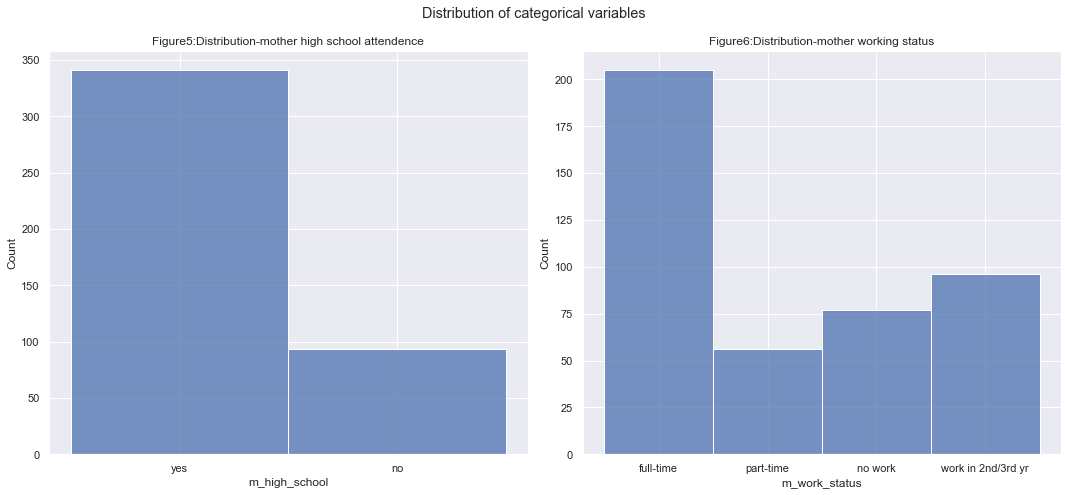

In [16]:
fig,ax = plt.subplots(1,2,figsize=(15,7))
fig.suptitle('Distribution of categorical variables')

sns.histplot(df.m_high_school,edgecolor="white",
             ax=ax[0])
ax[0].set_title('Figure5:Distribution-mother high school attendence')

sns.histplot(df.m_work_status,edgecolor="white",
             ax=ax[1])
ax[1].set_title('Figure6:Distribution-mother working status')
plt.xticks(['no work','work in 2nd/3rd yr','part-time','full-time'])

plt.tight_layout()
plt.show()

In Figure5 and Figure6, it seems that there is not highly unbalanced in the dataset.

###  Bivariate Analysis

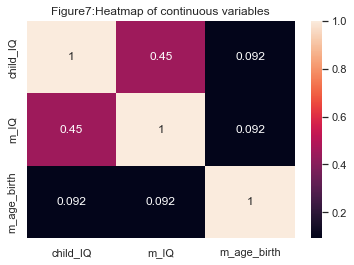

In [17]:
df_num=df[['child_IQ','m_IQ','m_age_birth']]
corr = df_num.corr()

# Create heatmap with correlations
fig,ax = plt.subplots(1,1,figsize=(6,4))
sns.heatmap(corr, annot=True, ax=ax)
ax.set_title('Figure7:Heatmap of continuous variables')

plt.show()

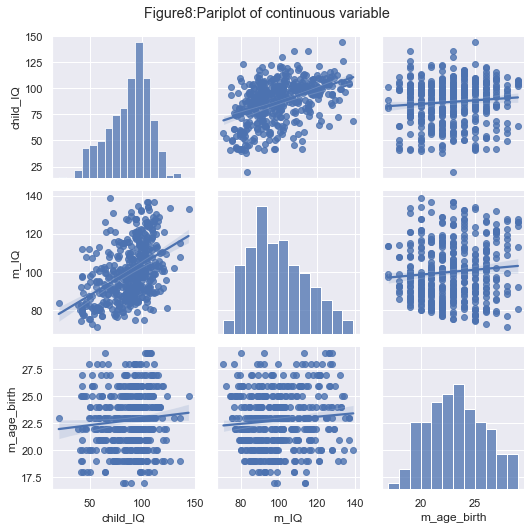

In [18]:
fig8 = sns.pairplot(df_num, kind='reg')
fig8.fig.suptitle('Figure8:Pariplot of continuous variable')
plt.tight_layout()
plt.show()

Figure7 and Figure8 shows the pair-wise relation between 'child_IQ', 'm_IQ' and 'm_age_birth':
1. Mother's IQ('m_IQ) is relatively high-related(cor=0.45) with children's IQ(child_IQ)
2. Mother'age at child's birth(m_age_birth) is less related(cor=0.092) with children's IQ(child_IQ)
2. Also, there is no high correlation between 'm_age_birth' and 'm_IQ'(cor=0.092)

So, 'm_IQ' could be one of the main predictors for 'child_IQ'. And it will be the predictor in univariate regression.

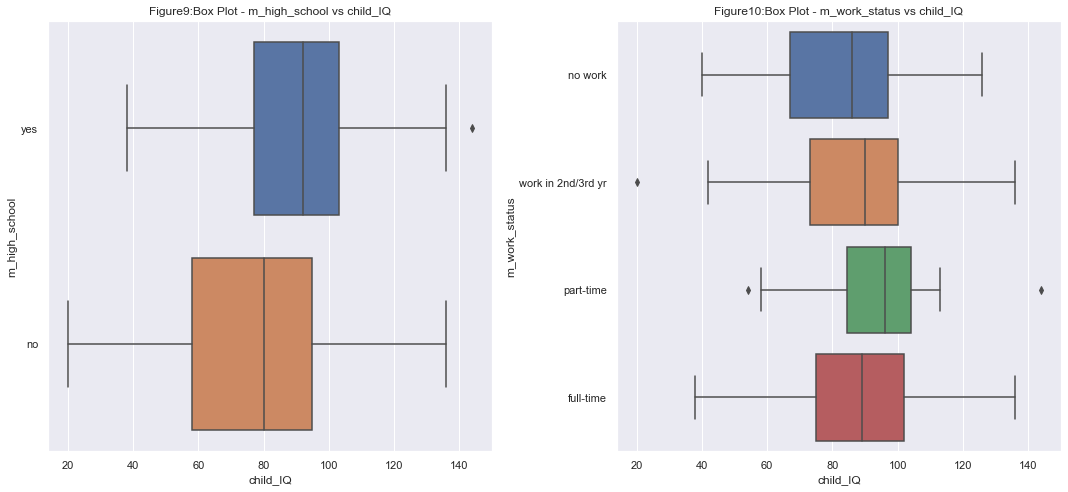

In [19]:
fig,ax = plt.subplots(1,2,figsize=(15,7))

sns.boxplot(data=df, x='child_IQ',y='m_high_school',ax=ax[0])
ax[0].set_title('Figure9:Box Plot - m_high_school vs child_IQ')

sns.boxplot(data=df, x='child_IQ',y='m_work_status',
            order=['no work','work in 2nd/3rd yr','part-time','full-time'],
            ax=ax[1])
ax[1].set_title('Figure10:Box Plot - m_work_status vs child_IQ')

plt.tight_layout()
plt.show()

Figure9 and Figure10 describe the relationship of 'm_high_school' and 'm_work_status' with 'child_IQ'. It is found that:
1. Mothers who have completed high school tend to have children with higher IQ
2. There is no obvious relation between 'm_work_status' with 'child_IQ'. However, mothers who have no work in first three years of child’s life seem to have lower-IQ children. So, it might be helpful to collapse the 'm_work_status' by work and no-work.

In [20]:
# Create a dummy variable indicating work(1) and no-work(0)
ws_mapping = {1:0, 2:1, 3:1, 4:1}
df['dummy_m_work_status'] = df['m_work_status_idx'].map(ws_mapping)

# categorical variable corresponding to dummy_m_work_status
ws_mapping2 = {1:'work', 0:'no work'}
df['m_work_status2'] = df['dummy_m_work_status'].map(ws_mapping2) 
# Check the mapping
df[['m_work_status_idx','dummy_m_work_status']].value_counts()

m_work_status_idx  dummy_m_work_status
4                  1                      205
2                  1                       96
1                  0                       77
3                  1                       56
dtype: int64

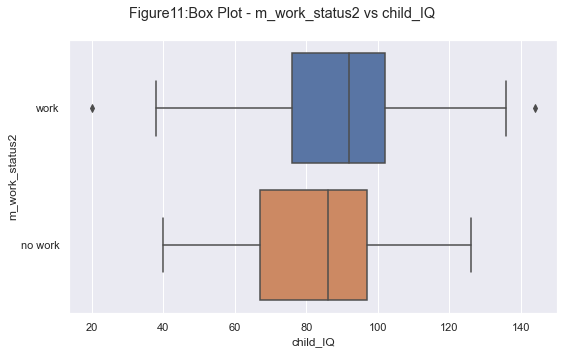

In [21]:
fig,ax = plt.subplots(1,1,figsize=(8,5))
fig.suptitle('Figure11:Box Plot - m_work_status2 vs child_IQ')
sns.boxplot(data=df, x='child_IQ',y='m_work_status2',ax=ax)
plt.tight_layout()
plt.show()

Figure 11 shows that children having mothers with work in their first 3 years have slightly higher IQ than those whose mother having no work. So, in further analysis, the collapsed dummy variable 'dummy_m_work_status' will be used.

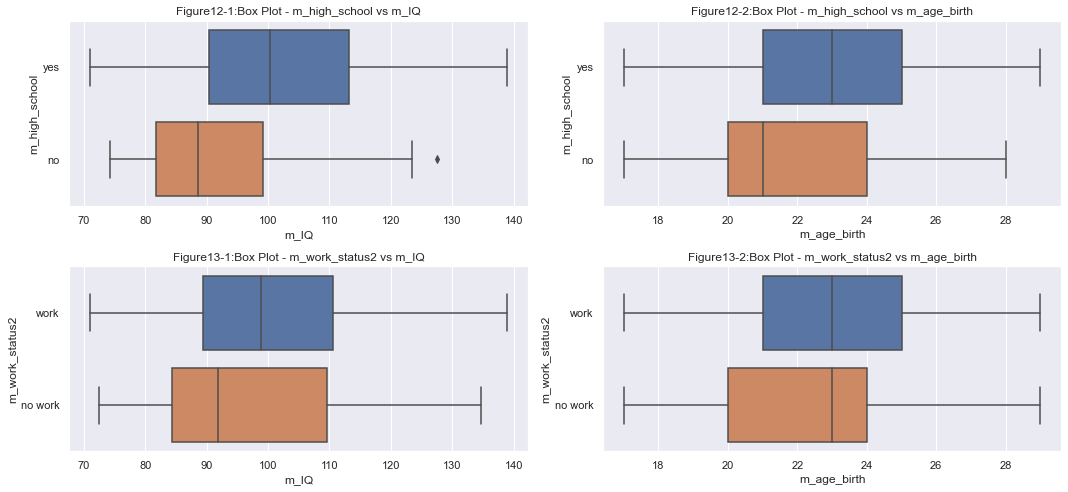

In [22]:
## Corelation between 2 categorical and 2 continuous predictors
fig,ax = plt.subplots(2,2,figsize=(15,7))

sns.boxplot(data=df, x='m_IQ',y='m_high_school',ax=ax[0,0])
ax[0,0].set_title('Figure12-1:Box Plot - m_high_school vs m_IQ')
sns.boxplot(data=df, x='m_age_birth',y='m_high_school',ax=ax[0,1])
ax[0,1].set_title('Figure12-2:Box Plot - m_high_school vs m_age_birth')

sns.boxplot(data=df, x='m_IQ',y='m_work_status2',ax=ax[1,0])
ax[1,0].set_title('Figure13-1:Box Plot - m_work_status2 vs m_IQ')
sns.boxplot(data=df, x='m_age_birth',y='m_work_status2',ax=ax[1,1])
ax[1,1].set_title('Figure13-2:Box Plot - m_work_status2 vs m_age_birth')

plt.tight_layout()
plt.show()

Figure12 and Figure13 shows that there is obvious positive correlation in:
* 'm_high_school' and 'm_IQ': mother who completed high school tend to have a higher IQ
* 'm_high_school' and 'm_age_birth': mother who completed high school tend to give birth in a higher age
* 'm_work_status2' and 'm_IQ': mother who had work in the first three years after child's birth had a higher IQ

These correlations indicate that there may be colinearity problem, so model selection or regularity would be needed for regression.

### Explore for interaction effect

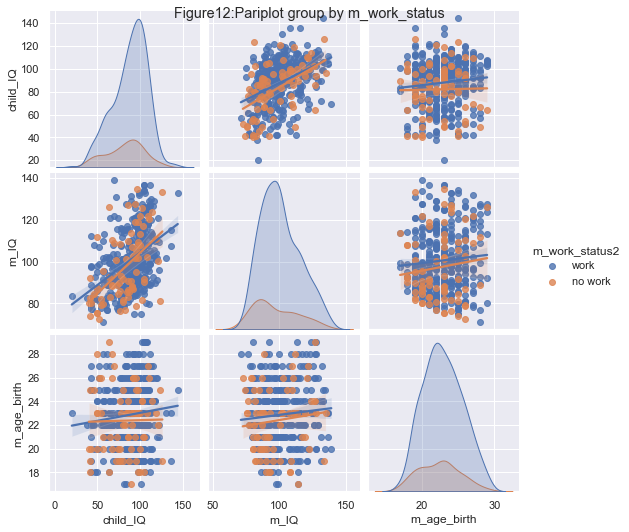

In [23]:
fig12 = sns.pairplot(data=df,kind='reg',
                     vars=['child_IQ', 'm_IQ', 'm_age_birth'],
                     hue='m_work_status2')
fig12.fig.suptitle('Figure12:Pariplot group by m_work_status')

plt.show()

Figure12 is the pair plot, which was groupped by mother's work status(work vs no-work) in child's first 3 years. It is shown that the regression line in each plot is very near, indicating that interaction effect of 'm_work_status2' is trivial.

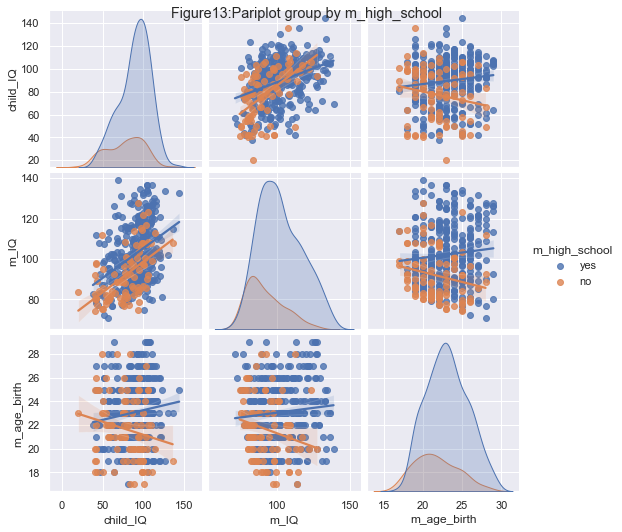

In [24]:
fig13 = sns.pairplot(data=df,kind='reg',
                     vars=['child_IQ', 'm_IQ', 'm_age_birth'],
                     hue='m_high_school')
fig13.fig.suptitle('Figure13:Pariplot group by m_high_school')
plt.show()

However when looking at the interaction effect of 'm_high_school', the first row of the plot shows that:
1. For those mother who completed high school, mother's IQ has a lower effect on child's IQ.
2. For those mother who completed high school, mother's birth age has a higher effect on child's IQ. However, similar effect apears on mother's IQ, which means this interaction effect of 'm_high_school' between 'm_birth_age' and 'child_IQ' might replaced by 'm_IQ'. But it can still be worthwhile to be taken into account in modeling.

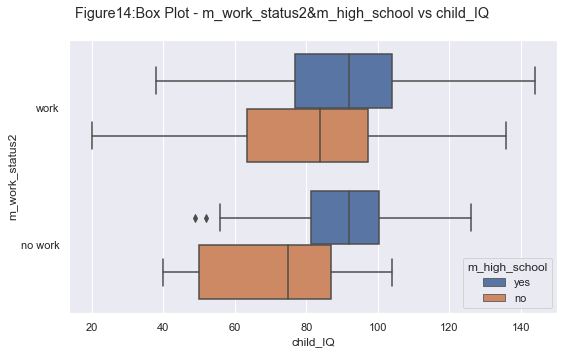

In [25]:
fig,ax = plt.subplots(1,1,figsize=(8,5))
fig.suptitle('Figure14:Box Plot - m_work_status2&m_high_school vs child_IQ')
sns.boxplot(data=df, 
            x='child_IQ',y='m_work_status2',hue='m_high_school',
            ax=ax)
plt.tight_layout()
plt.show()

Figure14 shows the interaction effect of 'm_work_status2' and 'm_high_school' is NOT obvious.

### Summary
1. As regressand, 'child_IQ' is not quite normally distributed. so transformed child_IQ will be used as regressand in linear regression (Box-Cox transformation with lambda = 1.62 was applied)
2. m_IQ should be an essential predictor for child_IQ
3. m_work_status is collapsed into a dummy variable for further analysis
4. For interaction effect, two interaction can be considered in the model: 
    * m_high_school and m_IQ
    * m_high_school and m_age_birth
5. Colinearity problem need to be concerned

## Linear regression
### Linear regression with single predictor
For regression with single variable, m_IQ is chosen here as the predictor. So the basic model assumption is

$$ y = \beta_{0} + \beta_{1} * x + \varepsilon $$

where y is transformed child IQ and x is mother IQ

In [26]:
from statsmodels.compat import lzip
import statsmodels.formula.api as smf
import statsmodels.stats.api as sms

y = trans_c_IQ
x1 = df['m_IQ']
x1 = sm.add_constant(x1)

slr = sm.OLS(y,x1).fit()
slr.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.201
Model:                            OLS   Adj. R-squared:                  0.199
Method:                 Least Squares   F-statistic:                     108.7
Date:                Fri, 13 Jan 2023   Prob (F-statistic):           7.46e-23
Time:                        15:05:52   Log-Likelihood:                -3066.0
No. Observations:                 434   AIC:                             6136.
Df Residuals:                     432   BIC:                             6144.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        -62.0886     91.913     -0.676      0.500    -242.740     118.563
m_IQ           9.4773      0.909     10.426      0.000       7.691      11.264
==============================================================================
Omnibus:                        0.105   Durbin-Watson:                   1.638
Prob(Omnibus):                  0.949   Jarque-Bera (JB):                0.196
Skew:                           0.024   Prob(JB):                        0.907
Kurtosis:                       2.908   Cond. No.                         682.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Based on the result above, the model estimation is 

$$
\hat y=-62.09+9.48\times\text{m_IQ}
$$

**Model goodness of fit**
1. p value of F statistics is less than 0.05, which indicates that the model is effective. 
2. $R^2$ is 0.201, saying that there is 20.1% of variance of y can be expained by x(mother IQ)

**Model interpretation**

The coefficient of 'm_IQ' is 9.48(significant), which means when mother's IQ increases by 1 unit, transformed child IQ will increase by 9.48 on average

**Regression Diagnostics**
1. **Normality of the residuals**: The p-values of Jarque-Bera and Ominibus Test in the table above are 0.907 and 0.949(>0.05), so there is not sufficient evidence to reject the residuals are normally-distributed
2. **Heteroskedasticity tests**: Both p-value of Breush-Pagan test and Goldfeld-Quandt test is larger than 0.05, so there is no enough evidence that heteroskedasticity exists
3. **Multicollinearity**: No multicollinearity for single predictor.
4. **Linearity**: the Harvey-Collier test indicate that the relationship is not linear. But this is the regression with only 1 predictor. It might be helpful to add more predictors to the model.
5. **Influence tests**: Here Cook's distance is used to detect high influential points. There is no point whose Cook's distance is larger than 1, so basically no influential point is detected.
6. **residual plot**: The residual plot shows that the residuals distributed evenly on both sides of zero and did not show any sign of Heteroskedasticity or trend.
7. **Autocorrelation**: From the Durbin-Watson Test, the DW Statistics is 1.64, which is not far from 2 suggesting that the autocorrelation is small.

In [27]:
## Heteroskedasticity tests
# Breush-Pagan test
name = ["Lagrange multiplier statistic", "p-value", "f-value", "f p-value"]
test = sms.het_breuschpagan(slr.resid, slr.model.exog)
lzip(name, test)

[('Lagrange multiplier statistic', 0.631586722987298),
 ('p-value', 0.4267738902150974),
 ('f-value', 0.6295924113788604),
 ('f p-value', 0.4279404520466825)]

In [28]:
## Heteroskedasticity tests
# Goldfeld-Quandt test
name = ["F statistic", "p-value"]
test = sms.het_goldfeldquandt(slr.resid, slr.model.exog)
lzip(name, test)

[('F statistic', 1.1010393281971416), ('p-value', 0.2404895526166621)]

In [29]:
# Linearity-Harvey-Collier test
name = ["t value", "p value"]
test = sms.linear_harvey_collier(slr)
lzip(name, test)

[('t value', -2.7659831109365354), ('p value', 0.005919657307216007)]

In [30]:
from statsmodels.stats.outliers_influence import OLSInfluence

cook_dis = OLSInfluence(slr).summary_frame().iloc[:,2]
cook_dis[cook_dis>1]

Series([], Name: cooks_d, dtype: float64)

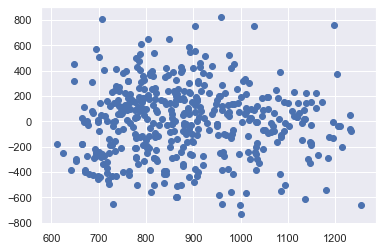

In [32]:
plt.scatter(x=slr.predict(), y=slr.resid)

### Linear regression with multiple predictors
In this part, multiple predictors are included in the regression. And forward model selection method is applied to select variables and simplify the model.

In [33]:
x = df[['m_age_birth','m_high_school_idx',
         'dummy_m_work_status','m_IQ']]
x = sm.add_constant(x)
mlr = sm.OLS(y,x).fit()
mlr.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.215
Model:                            OLS   Adj. R-squared:                  0.208
Method:                 Least Squares   F-statistic:                     29.40
Date:                Fri, 13 Jan 2023   Prob (F-statistic):           1.28e-21
Time:                        16:28:48   Log-Likelihood:                -3062.2
No. Observations:                 434   AIC:                             6134.
Df Residuals:                     429   BIC:                             6155.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                -169.6384    143.386     -1.183      0.237    -451.464     112.187
m_age_birth             3.9319      5.144      0.764      0.445      -6.179      14.043
m_high_school_idx      70.0263     35.998      1.945      0.052      -0.728     140.780
dummy_m_work_status    38.9268     36.560      1.065      0.288     -32.933     110.787
m_IQ                    8.7865      0.943      9.316      0.000       6.933      10.640
==============================================================================
Omnibus:                        0.083   Durbin-Watson:                   1.605
Prob(Omnibus):                  0.959   Jarque-Bera (JB):                0.168
Skew:                           0.021   Prob(JB):                        0.920
Kurtosis:                       2.913   Cond. No.                     1.10e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.1e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [34]:
x = x.drop(columns='m_age_birth')
mlr = sm.OLS(y,x).fit()
mlr.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.214
Model:                            OLS   Adj. R-squared:                  0.209
Method:                 Least Squares   F-statistic:                     39.04
Date:                Fri, 13 Jan 2023   Prob (F-statistic):           2.49e-22
Time:                        16:28:53   Log-Likelihood:                -3062.5
No. Observations:                 434   AIC:                             6133.
Df Residuals:                     430   BIC:                             6149.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                 -86.9120     94.007     -0.925      0.356    -271.683      97.859
m_high_school_idx      75.2100     35.336      2.128      0.034       5.757     144.663
dummy_m_work_status    39.4538     36.536      1.080      0.281     -32.358     111.266
m_IQ                    8.8101      0.942      9.350      0.000       6.958      10.662
==============================================================================
Omnibus:                        0.088   Durbin-Watson:                   1.606
Prob(Omnibus):                  0.957   Jarque-Bera (JB):                0.179
Skew:                           0.018   Prob(JB):                        0.914
Kurtosis:                       2.907   Cond. No.                         706.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [35]:
x = x.drop(columns='dummy_m_work_status')
mlr = sm.OLS(y,x).fit()
mlr.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.212
Model:                            OLS   Adj. R-squared:                  0.208
Method:                 Least Squares   F-statistic:                     57.95
Date:                Fri, 13 Jan 2023   Prob (F-statistic):           5.12e-23
Time:                        16:29:06   Log-Likelihood:                -3063.1
No. Observations:                 434   AIC:                             6132.
Df Residuals:                     431   BIC:                             6144.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const               -63.0512     91.391     -0.690      0.491    -242.679     116.576
m_high_school_idx    83.9399     34.406      2.440      0.015      16.316     151.564
m_IQ                  8.8274      0.942      9.368      0.000       6.975      10.679
==============================================================================
Omnibus:                        0.137   Durbin-Watson:                   1.618
Prob(Omnibus):                  0.934   Jarque-Bera (JB):                0.239
Skew:                           0.022   Prob(JB):                        0.887
Kurtosis:                       2.894   Cond. No.                         683.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Finally, only 'm_IQ' and 'm_high_school_idx' are left in model. The estimate for the model is

$$
\hat y=-63.05+83.94\times \text{m_high_school_idx}+8.83\times\text{m_IQ}
$$

**Model goodness of fit**
1. p value of F statistics is less than 0.05, which indicates that the model is effective. 
2. $R^2$ is 0.212, saying that there is 21.2% of variance of y can be expained by x(mother IQ). Compared to previous model($R^2=0.201$), $R^2$ do not have much more improvement

**Model interpretation**
1. The coefficient of 'm_IQ' is 8.83, which means when 'm_high_school_idx' keeps the same, if mother's IQ increases by 1 unit, transformed child IQ will increase by 8.83 on average
2. The coefficient of 'm_high_school_idx' is 83.94, which means when 'm_IQ' keeps the same, transformed child IQ with mother who completed high school education will be higher by 83.94 on average than whose children whose mother did not complete high school. This coefficient is quite wierd in reality because it is hard to understand when given mother's IQ, mother's high school attendance would play such an important role in child's IQ. I would like to see whether it would be helpful to include interaction terms to solve this problem.

**Regression Diagnostics**
1. **Normality of the residuals**: The p-values of Jarque-Bera and Ominibus Test show in the table above are larger than 0.05, so there is not sufficient evidence to reject the residuals are normally-distributed
2. **Heteroskedasticity tests**: Both p-value of Breush-Pagan test and Goldfeld-Quandt test is larger than 0.05, so there is no enough evidence that heteroskedasticity exists
3. **Multicollinearity**: there is no much collinearity between 'm_IQ' and 'm_high_school_idx'. VIF also indicates that there is no severe multilinear problem in the model.
4. **Linearity**: Harvey Collier test for linearity in this model became ineffective.From the residual plot, it is hard to seen any non-linear symptom
5. **Influence tests**: Still, there is no point whose Cook's distance is larger than 1, so basically no influential point is detected.
6. **residual plot**: The residual plot shows that the residuals distributed evenly on both sides of zero and did not show any sign of Heteroskedasticity or trend.
7. **Autocorrelation**: From the Durbin-Watson Test, the DW Statistics is 1.62, which is not far from 2 suggesting that the autocorrelation is small

In [36]:
## Heteroskedasticity tests
# Breush-Pagan test
name = ["Lagrange multiplier statistic", "p-value", "f-value", "f p-value"]
test = sms.het_breuschpagan(mlr.resid, mlr.model.exog)
lzip(name, test)

[('Lagrange multiplier statistic', 0.2130689434753168),
 ('p-value', 0.89894405946333),
 ('f-value', 0.10585002458948006),
 ('f p-value', 0.8995829272708268)]

In [37]:
## Heteroskedasticity tests
# Goldfeld-Quandt test
name = ["F statistic", "p-value"]
test = sms.het_goldfeldquandt(mlr.resid, mlr.model.exog)
lzip(name, test)

[('F statistic', 1.053952338703742), ('p-value', 0.35053404661868975)]

In [38]:
# Multicollinearity-VIF
from statsmodels.stats.outliers_influence import variance_inflation_factor
vif_data = pd.DataFrame()
vif_data["feature"] = x.columns
  
# calculating VIF for each feature
vif_data["VIF"] = [variance_inflation_factor(x.values, i)
                          for i in range(len(x.columns))]
  
print(vif_data)

             feature        VIF
0              const  45.547937
1  m_high_school_idx   1.086867
2               m_IQ   1.086867


In [39]:
cook_dis = OLSInfluence(mlr).summary_frame().iloc[:,2]
cook_dis[cook_dis>1]

Series([], Name: dfb_m_IQ, dtype: float64)

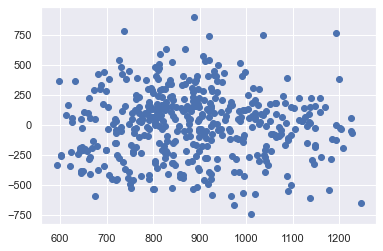

In [40]:
plt.scatter(x=mlr.predict(), y=mlr.resid)

### Linear Regression with multiple predictors and interaction term

In [43]:
x = df[['m_age_birth','m_high_school_idx',
         'dummy_m_work_status','m_IQ']]
x = sm.add_constant(x)
x['age_x_highschool']= x['m_age_birth']*x['m_high_school_idx']
x['mIQ_x_highschool']= x['m_IQ']*x['m_high_school_idx']
mlr2 = sm.OLS(y,x).fit()
mlr2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.234
Model:                            OLS   Adj. R-squared:                  0.223
Method:                 Least Squares   F-statistic:                     21.71
Date:                Fri, 13 Jan 2023   Prob (F-statistic):           2.70e-22
Time:                        16:41:30   Log-Likelihood:                -3057.0
No. Observations:                 434   AIC:                             6128.
Df Residuals:                     427   BIC:                             6156.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                -349.4536    354.661     -0.985      0.325   -1046.553     347.645
m_age_birth            -9.7193     10.934     -0.889      0.375     -31.210      11.772
m_high_school_idx     242.6260    392.058      0.619      0.536    -527.978    1013.230
dummy_m_work_status    28.8124     36.413      0.791      0.429     -42.759     100.383
m_IQ                   14.0348      2.373      5.915      0.000       9.371      18.699
age_x_highschool       19.8559     12.382      1.604      0.110      -4.482      44.193
mIQ_x_highschool       -6.4931      2.588     -2.509      0.012     -11.579      -1.407
==============================================================================
Omnibus:                        0.033   Durbin-Watson:                   1.646
Prob(Omnibus):                  0.984   Jarque-Bera (JB):                0.109
Skew:                           0.003   Prob(JB):                        0.947
Kurtosis:                       2.923   Cond. No.                     5.25e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.25e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [44]:
x=x.drop(columns='m_high_school_idx')
mlr2 = sm.OLS(y,x).fit()
mlr2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.233
Model:                            OLS   Adj. R-squared:                  0.224
Method:                 Least Squares   F-statistic:                     26.01
Date:                Fri, 13 Jan 2023   Prob (F-statistic):           6.02e-23
Time:                        16:45:58   Log-Likelihood:                -3057.2
No. Observations:                 434   AIC:                             6126.
Df Residuals:                     428   BIC:                             6151.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                -150.6816    150.286     -1.003      0.317    -446.072     144.709
m_age_birth           -14.6138      7.544     -1.937      0.053     -29.443       0.215
dummy_m_work_status    30.8804     36.233      0.852      0.395     -40.337     102.098
m_IQ                   13.0262      1.723      7.558      0.000       9.639      16.414
age_x_highschool       25.8866      7.633      3.391      0.001      10.883      40.890
mIQ_x_highschool       -5.3332      1.783     -2.991      0.003      -8.838      -1.829
==============================================================================
Omnibus:                        0.032   Durbin-Watson:                   1.644
Prob(Omnibus):                  0.984   Jarque-Bera (JB):                0.107
Skew:                           0.005   Prob(JB):                        0.948
Kurtosis:                       2.924   Cond. No.                     1.53e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.53e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [45]:
x=x.drop(columns='dummy_m_work_status')
mlr2 = sm.OLS(y,x).fit()
mlr2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.232
Model:                            OLS   Adj. R-squared:                  0.225
Method:                 Least Squares   F-statistic:                     32.35
Date:                Fri, 13 Jan 2023   Prob (F-statistic):           1.41e-23
Time:                        16:46:06   Log-Likelihood:                -3057.5
No. Observations:                 434   AIC:                             6125.
Df Residuals:                     429   BIC:                             6145.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const             -129.3444    148.139     -0.873      0.383    -420.513     161.824
m_age_birth        -15.0140      7.527     -1.995      0.047     -29.809      -0.219
m_IQ                13.1070      1.720      7.619      0.000       9.726      16.488
age_x_highschool    26.5489      7.591      3.497      0.001      11.628      41.469
mIQ_x_highschool    -5.4193      1.780     -3.045      0.002      -8.917      -1.921
==============================================================================
Omnibus:                        0.053   Durbin-Watson:                   1.654
Prob(Omnibus):                  0.974   Jarque-Bera (JB):                0.137
Skew:                           0.008   Prob(JB):                        0.934
Kurtosis:                       2.915   Cond. No.                     1.51e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.51e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Finally, after forward selection, 'm_IQ' and 'm_age_birth' and both interaction are left in model. The coefficients are all significant. And the final model is:

$$
\hat y=-129.34-15.01\times \text{m_age_birth}+13.11\times\text{m_IQ}\\
+26.55\times\text{age_x_highschool}\\
-5.42\times\text{mIQ_x_highschool}
$$

**Model goodness of fit**
1. p value of F statistics is less than 0.05, which indicates that the model is effective. 
2. $R^2$ is 0.232, saying that there is 23.2% of variance of y can be expained by x(mother IQ). Compared to previous model, there is 2% of improvement in $R^2$.

**Model interpretation**
1. The coefficient of 'm_IQ' is 13.11, and the coefficient of the interaction term 'mIQ_x_highschool'is -5.42, so keeping other variable constant: 
    * For those whose mother did not finish high school('m_high_school_idx'=0), if mother's IQ increases by 1 unit, transformed child IQ will increase by 13.11 on average
    * For those whose mother finished high school('m_high_school_idx'=1), if mother's IQ increases by 1 unit, transformed child IQ will increase by 7.69(13.11-5.42) on average

2. The coefficient of 'm_age_birth' is -15.01, and coefficient of the interaction term 'age_x_highschool'is 26.55. Therefore, keeping other variable constant: 
    * For those whose mother did not finish high school('m_high_school_idx'=0), if mother's birth age increases by 1,  transformed child IQ will decrease by 15.01 on average
    * For those whose mother finished high school('m_high_school_idx'=1), if mother's birth age increases by 1, transformed child IQ will increase by 11.54(26.55-15.01) on average
3. For interaction effect, if m_high_school change from 0 to 1, the effect of mother birth age on child IQ changed from negative to positive(-15.01 to 11.54); however, the effect of mother IQ change from 13.11 to 7.69 (13.11-5.42)

**Regression Diagnostics**
1. **Normality of the residuals**: The p-values of Jarque-Bera and Ominibus Test in the table above are 0.934 and 0.974(>0.05), so there is not sufficient evidence to reject the residuals are normally-distributed.
2. **Heteroskedasticity tests**: no sufficient evidence for Heteroskedasticity based on Breush-Pagan test and Goldfeld-Quandt test below.
3. **Multicollinearity**:there is Multicollinearity problem because interaction terms exist in the model indicating by VIF and condition number
4. **Linearity**: Harvey Collier test for linearity in this model became ineffective.From the residual plot, it is hard to seen any non-linear symptom
5. **Influence tests**: no influential point based on cook's distance
6. **residual plot**: The residual plot shows that the residuals distributed evenly on both sides of zero and did not show any sign of Heteroskedasticity or trend.
7. **Autocorrelation**: From the Durbin-Watson Test, the DW Statistics is 1.65, which is not far from 2 suggesting that the autocorrelation is small

In [46]:
## Heteroskedasticity tests
# Breush-Pagan test
name = ["Lagrange multiplier statistic", "p-value", "f-value", "f p-value"]
test = sms.het_breuschpagan(mlr2.resid, mlr2.model.exog)
lzip(name, test)

[('Lagrange multiplier statistic', 0.830162141913471),
 ('p-value', 0.9343592791445624),
 ('f-value', 0.2055426808119318),
 ('f p-value', 0.9352979056556449)]

In [47]:
## Heteroskedasticity tests
# Goldfeld-Quandt test
name = ["F statistic", "p-value"]
test = sms.het_goldfeldquandt(mlr2.resid, mlr2.model.exog)
lzip(name, test)

[('F statistic', 1.042930283601866), ('p-value', 0.37993836628776445)]

In [48]:
# Multicollinearity-VIF
vif_data = pd.DataFrame()
vif_data["feature"] = x.columns
  
# calculating VIF for each feature
vif_data["VIF"] = [variance_inflation_factor(x.values, i)
                          for i in range(len(x.columns))]
  
print(vif_data)

            feature         VIF
0             const  122.187361
1       m_age_birth    2.296393
2              m_IQ    3.698706
3  age_x_highschool   30.518375
4  mIQ_x_highschool   34.062702


In [49]:
cook_dis = OLSInfluence(mlr2).summary_frame().iloc[:,2]
cook_dis[cook_dis>1]

Series([], Name: dfb_m_IQ, dtype: float64)

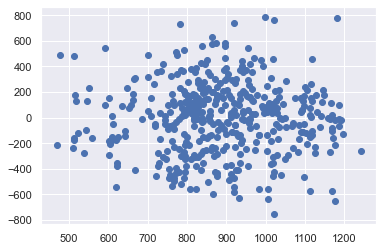

In [50]:
plt.scatter(x=mlr2.predict(), y=mlr2.resid)

### Summary and Further Discussion

#### Summary

Based on the results of models, the model with interaction provides a more reasonable parametres than multivariate model because as mentioned in the multivariate model, the coefficient of 'm_high_school_idx' seems not make sense. Also, the last model has a better $R^2$ and lower AIC,BIC, even though the $R^2$ is only 23.2% 

The effect of variables: 
1. Mother's IQ always has a positive effect on child's IQ
2. The effect of mother's age at child's birth on child's IQ is associated with m_high_school.
3. 'm_work_status' do not play a role in the final model
4. 'm_high_school' is as moderator variable in the model with 'm_IQ' and 'm_age_birth'.

#### Further Discussion
The model does not give a very satisfying result to predict child's IQ. In my opinion, there may be several ways to try:
1. Polynomial regression. Even the residual did not show obvious polynomial effect. However, it is reasonable to think that when mother's IQ become larger, it will have less effect on child'IQ.
2. Add more feature or more observations to the data. Child's IQ maybe related to their own age and their father's feature.
3. Normalize all data.For this dataset, the age, m_IQ and child_IQ are definitely large than 0. It may be helpful to normalize the variables.
4. Try more flexible models. Flexible models is more likely to have more precise prediction.